In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
!pip install https://github.com/fastai/fastai/archive/1.0.49.zip

     \ 163.3MB 98.2MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-n270xp3p/wheels/1e/50/f4/007e761a28dd5b03ad92df65bbef5a8a84b799052298cb44a0
Successfully built fastai
  Found existing installation: fastai 1.0.50.post1
    Uninstalling fastai-1.0.50.post1:
      Successfully uninstalled fastai-1.0.50.post1


In [0]:
from fastai.vision import *
from fastai.callbacks import *
import torchvision
import torch

In [0]:
from pathlib import Path

In [0]:
bs = 128

## Downloading data

In [0]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
!mkdir data/models
!!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -P data/models/

In [0]:
!unzip -q data.zip -d data #Dataset

In [0]:
!ls

data  models


In [0]:
!ls data

models	test_WyRytb0.csv  train  train.csv


In [0]:
path = Path("./data/")
train_path = path/'train.csv'
test_path = path/'test_WyRytb0.csv'
train_path, test_path

(PosixPath('data/train.csv'), PosixPath('data/test_WyRytb0.csv'))

In [0]:
import os
import shutil

In [0]:
os.mkdir(path/'test')

In [0]:
with open(path/'test_WyRytb0.csv') as f:
  fnames = f.read().split()
  for name in fnames:
    try:
      shutil.copy(path/'train'/name, path/'test'/name)
    except Exception as e:
      print(e, "can't copy "+name)

[Errno 2] No such file or directory: 'data/train/image_name' can't copy image_name


In [0]:
seed = 42

# python RNG
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [0]:
import torchvision
import torch
from collections import OrderedDict

In [0]:
places_res50 = torch.load('data/models/resnet50_places365.pth.tar',  map_location=lambda storage, loc: storage)

In [0]:
default_res50 = models.resnet50()
state_dict = places_res50['state_dict'] 
new_state_dict = OrderedDict()

In [0]:
for key in model_state_dict.keys():
  new_state_dict[key[7:]]= state_dict[key]
  

In [0]:
default_res50.fc = torch.nn.Linear(2048, 365) # Matching with default res50 dense layer
default_res50.load_state_dict(new_state_dict)

In [0]:
def new_resnet(prtn):
  return default_res50

In [0]:
data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train.csv', test='test', ds_tfms=get_transforms(), size=128, bs=bs, num_workers=1).normalize(imagenet_stats)

In [0]:
def get_data(sz, bs):
  data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train.csv', test='test', ds_tfms=get_transforms(), size=sz, bs=bs, num_workers=1).normalize(imagenet_stats)
  return data

In [0]:
df_lowest_conf = pd.read_csv('lowest_confidence.csv')

In [0]:
!cp data/train.csv data/train_old.csv
new_train_df = pd.read_csv(path/'train.csv')
new_train_df = new_train_df[~new_train_df['image_name'].isin(df_lowest_conf['image_name'])]
new_train_df.to_csv(path/'train.csv', index=False)

In [0]:
learn = cnn_learner(get_data(224, 64), new_resnet, metrics=[error_rate, accuracy])

In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.268112,0.188795,0.070939,0.929061,04:21
1,0.214205,0.164201,0.059613,0.940387,04:09
2,0.187953,0.147449,0.051267,0.948733,04:11
3,0.154553,0.146573,0.051565,0.948435,04:11
4,0.126961,0.140639,0.050671,0.949329,04:10


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


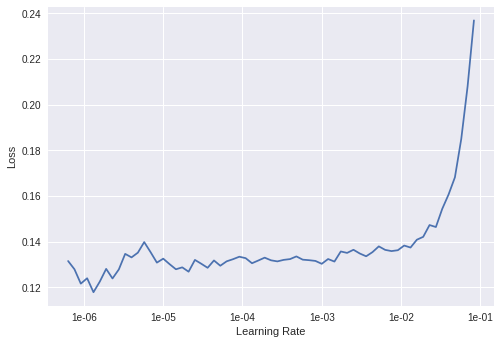

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(6, max_lr=2e-06)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.140467,0.140303,0.050969,0.949031,04:10
1,0.133842,0.140776,0.050373,0.949627,04:12
2,0.127016,0.139000,0.050075,0.949925,04:10
3,0.126589,0.138672,0.051565,0.948435,04:12
4,0.118973,0.139166,0.049478,0.950522,04:10
5,0.128838,0.138840,0.049776,0.950224,04:13


In [0]:
def make_submission(learn, filename):
  log_preds, test_labels = learn.get_preds(ds_type=DatasetType.Test)
  preds = np.argmax(log_preds, 1)
  a = np.array(preds)
  submission = pd.DataFrame({'image_name': os.listdir('data/test'), 'label': a})
  submission.to_csv(path/filename, index=False)

In [0]:
make_submission(learn, 'places_res50_224x224_confused_lr_seed.csv')

Test Accuracy => 	0.963013698630137

In [0]:
def make_submission_tta(learn, filename):
  log_preds, test_labels = learn.TTA(ds_type=DatasetType.Test)
  preds = np.argmax(log_preds, 1)
  a = np.array(preds)
  submission = pd.DataFrame({'image_name': os.listdir('data/test'), 'label': a})
  submission.to_csv(path/filename, index=False)

In [0]:
make_submission_tta(learn, 'places_res50_224x224_confused_lr_seed_tta.csv')

Test Accuracy => 0.963470319634703

In [0]:
learn.save('places_res50_224x224_confused_lr_seed')

## Classification Report

In [0]:
from sklearn.metrics import classification_report

In [0]:
data

ImageDataBunch;

Train: LabelList (13422 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,5,0,4,1
Path: data;

Valid: LabelList (3355 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
3,2,2,2,2
Path: data;

Test: LabelList (7301 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data

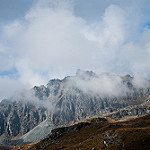

In [0]:
data.valid_ds.x[0]

In [0]:
data.valid_ds.y[0]

Category 3

In [0]:
log_preds, valid_labels = learn.get_preds(ds_type=DatasetType.Valid)

In [0]:
valid_labels

tensor([5, 1, 1,  ..., 2, 5, 3])

In [0]:
valid_preds = np.argmax(log_preds, 1)

In [0]:
valid_preds

tensor([5, 1, 3,  ..., 2, 5, 3])

In [0]:
target_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [0]:
cls_report = classification_report(valid_labels, valid_preds, target_names=target_names)

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(valid_labels, valid_preds)

array([[436,   2,   0,   0,   1,  27],
       [  0, 564,   0,   2,   1,   0],
       [  2,   4, 538,  54,   7,   1],
       [  0,   1,  37, 561,   3,   1],
       [  2,   0,   4,   4, 518,   0],
       [ 13,   1,   0,   0,   0, 571]])

In [0]:
print(cls_report)

              precision    recall  f1-score   support

   buildings       0.96      0.94      0.95       466
      forest       0.99      0.99      0.99       567
     glacier       0.93      0.89      0.91       606
    mountain       0.90      0.93      0.92       603
         sea       0.98      0.98      0.98       528
      street       0.95      0.98      0.96       585

   micro avg       0.95      0.95      0.95      3355
   macro avg       0.95      0.95      0.95      3355
weighted avg       0.95      0.95      0.95      3355



## Mixup

In [0]:
learn_mix = cnn_learner(get_data(224, 64), new_resnet, metrics=[error_rate, accuracy]).mixup(alpha=0.1)

In [0]:
learn_mix.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.570724,0.181643,0.057526,0.942474,04:08
1,0.500890,0.182057,0.054844,0.945156,04:08
2,0.475463,0.172108,0.050075,0.949925,04:07
3,0.454395,0.161934,0.046498,0.953502,04:11
4,0.449823,0.166253,0.046498,0.953502,04:12


In [0]:
learn_mix.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


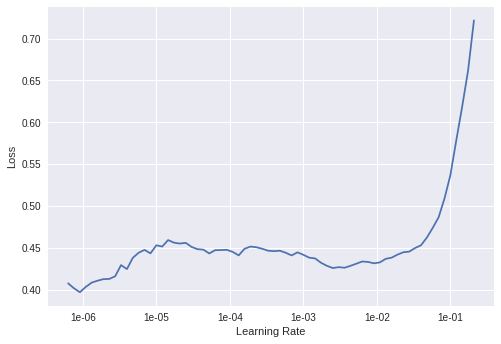

In [0]:
learn_mix.recorder.plot()

In [0]:
make_submission(learn_mix, 'places_res50_224x224_confused_mixup_seed.csv')

Test Accuracy => 	0.957990867579909

In [0]:
make_submission_tta(learn_mix, 'places_res50_224x224_confused_mixup_seed_tta.csv')

Test Accuracy => 0.961187214611872

In [0]:
learn_mix.fit_one_cycle(6, max_lr=1e-06)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.447605,0.165010,0.048286,0.951714,04:12
1,0.431904,0.165515,0.046498,0.953502,04:12
2,0.450312,0.164941,0.047392,0.952608,04:11
3,0.443465,0.164681,0.046200,0.953800,04:11
4,0.422798,0.164737,0.048286,0.951714,04:15
5,0.424876,0.163981,0.047392,0.952608,04:09


In [0]:
make_submission(learn_mix, 'places_res50_224x224_confused_lr_mixup_seed.csv')

Test Accuracy => 0.957990867579909

In [0]:
make_submission_tta(learn_mix, 'places_res50_224x224_confused_lr_mixup_seed_tta.csv')

Test Accuracy =>0.959817351598173

In [0]:
log_preds, valid_labels = learn_mix.get_preds(ds_type=DatasetType.Valid)

In [0]:
valid_labels

tensor([3, 5, 5,  ..., 5, 0, 1])

In [0]:
valid_preds = np.argmax(log_preds, 1)

In [0]:
valid_preds

tensor([3, 5, 5,  ..., 5, 0, 1])

In [0]:
target_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [0]:
cls_report = classification_report(valid_labels, valid_preds, target_names=target_names)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.confusion_matrix(slice_size=10)

array([[430,   2,   0,   0,   2,  32],
       [  0, 564,   0,   2,   1,   0],
       [  2,   2, 546,  49,   5,   2],
       [  0,   0,  40, 560,   2,   1],
       [  2,   0,   4,   4, 518,   0],
       [  8,   1,   0,   0,   0, 576]])

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(valid_labels, valid_preds)

array([[493,   0,   1,   1,   1,  25],
       [  0, 548,   0,   4,   0,   0],
       [  3,   3, 502,  51,   8,   0],
       [  1,   1,  42, 562,   2,   0],
       [  1,   0,   3,   1, 526,   1],
       [  9,   0,   0,   1,   0, 565]])

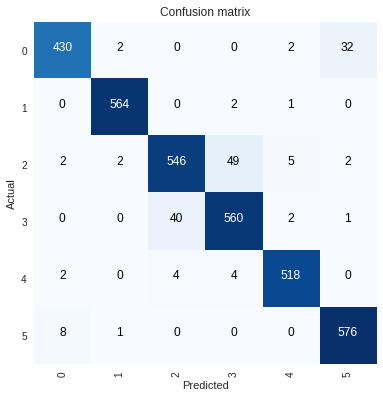

In [0]:
interp.plot_confusion_matrix(slice_size=10)

In [0]:
print(cls_report)

              precision    recall  f1-score   support

   buildings       0.97      0.95      0.96       521
      forest       0.99      0.99      0.99       552
     glacier       0.92      0.89      0.90       567
    mountain       0.91      0.92      0.92       608
         sea       0.98      0.99      0.98       532
      street       0.96      0.98      0.97       575

   micro avg       0.95      0.95      0.95      3355
   macro avg       0.95      0.95      0.95      3355
weighted avg       0.95      0.95      0.95      3355



In [0]:
learn_mix.save('places_res50_224x224_confused_lr_mixup_seed')

## Removing mixup and training further

In [0]:
learn_postmix = cnn_learner(get_data(224, 64), new_resnet, metrics=[error_rate, accuracy]).load('places_res50_224x224_confused_lr_mixup_seed')

In [0]:
learn_postmix.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


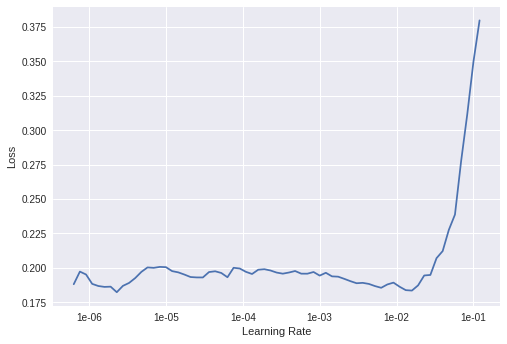

In [0]:
learn_postmix.recorder.plot()

In [0]:
learn_postmix.fit_one_cycle(5, max_lr=1e-06)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.195263,0.140523,0.031893,0.968107,04:13
1,0.184288,0.141899,0.030700,0.969300,04:08
2,0.192192,0.139931,0.031595,0.968405,04:12
3,0.190602,0.138912,0.030700,0.969300,04:11
4,0.189811,0.140477,0.030402,0.969598,04:12


In [0]:
make_submission(learn_mix, 'places_res50_224x224_confused_lr_postmixup_seed.csv')

Test Accuracy => 0.957990867579909

In [0]:
make_submission_tta(learn_mix, 'places_res50_224x224_confused_lr_postmixup_seed_tta.csv')

Test Accuracy => 0.96027397260274

## KNN Technique

In [0]:
!pip install annoy

    100% |████████████████████████████████| 645kB 23.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/77/cb/7a/6f3ed44099e394e0cb0b6b41213b61fe6595b726530744f2ce
Successfully built annoy


In [0]:
learn.load('places_res50_224x224_confused_lr_seed')

Learner(data=ImageDataBunch;

Train: LabelList (13422 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,4,5,0,1
Path: data;

Valid: LabelList (3355 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
5,1,1,4,5
Path: data;

Test: LabelList (7301 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1)

In [0]:
len(os.listdir('data/train'))

24335

We'll get activations first by adding all data to test set and batch size divisible by 24335 viz 157

In [0]:
from fastai.widgets import DatasetFormatter
from fastai.callbacks.hooks import hook_output

In [0]:
# We'll remove the transformations as well
def get_data_test(sz, bs):
  data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train.csv', test='train', size=sz, bs=bs, valid_pct=0).normalize(imagenet_stats)
  return data

In [0]:
data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train.csv', test='train', size=224, bs=157, valid_pct=0).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(get_data_test(224, 157), new_resnet, metrics=[error_rate, accuracy]).load('places_res50_224x224_confused_lr_seed')

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [0]:
layer_ls=[1, 4]

In [0]:
hook = hook_output(learn.model[layer_ls[0]][layer_ls[1]])

In [0]:
test_activations = DatasetFormatter.get_actns(learn, hook=hook, dl = data.test_dl, pool_dim=0, pool=False)

Getting activations...


In [0]:
test_activations.shape

torch.Size([24335, 512])

In [0]:
import pandas as pd
import numpy as np

In [0]:
# Train and Test is combined in train folder

In [0]:
all_df = pd.DataFrame({'image_name': os.listdir('data/train'), 'embeddings': list(test_activations.numpy())})
all_df.to_csv('embeddings.csv', index=False)

In [0]:
all_df.head()

,embeddings,image_name
0,"[0.44221514, 0.112893134, 12.497325, 16.80988,...",10297.jpg
1,"[1.1891145, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.20...",21676.jpg
2,"[0.0, 2.6557453, 12.751514, 15.589078, 9.45307...",9699.jpg
3,"[12.726483, 0.0, 0.0, 0.0, 0.35836467, 0.0, 0....",23947.jpg
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.190...",22981.jpg


In [0]:
test_df = pd.read_csv(path/'test_WyRytb0.csv')
train_df = pd.read_csv(path/'train.csv')

In [0]:
actual_train_df = all_df[all_df['image_name'].isin(train_df['image_name'])]
actual_train_df.shape

(16777, 2)

In [0]:
actual_test_df = all_df[all_df['image_name'].isin(test_df['image_name'])]
actual_test_df.shape

(7301, 2)

In [0]:
actual_test_df['index'] = actual_test_df.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_df['index'] = actual_train_df.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_df.head(10)

,embeddings,image_name,index
0,"[0.44221514, 0.112893134, 12.497325, 16.80988,...",10297.jpg,10297
1,"[1.1891145, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.20...",21676.jpg,21676
2,"[0.0, 2.6557453, 12.751514, 15.589078, 9.45307...",9699.jpg,9699
3,"[12.726483, 0.0, 0.0, 0.0, 0.35836467, 0.0, 0....",23947.jpg,23947
5,"[0.0, 3.794354, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17097.jpg,17097
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 6.5427957, 0.0, 0.0,...",13254.jpg,13254
7,"[0.5817962, 8.504057, 14.564641, 16.040916, 8....",23253.jpg,23253
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.98...",5393.jpg,5393
9,"[13.52926, 0.41330984, 0.0, 0.0, 0.05384856, 2...",6502.jpg,6502
11,"[0.0, 11.528537, 0.0, 7.9577627, 13.062908, 16...",17594.jpg,17594


In [0]:
from annoy import AnnoyIndex
import random

In [0]:
f = 512
a_index = AnnoyIndex(f, metric="angular")  # Length of item vector that will be indexed

In [0]:
for row in actual_train_df.iterrows():
  a_index.add_item(row[1]['index'], row[1].embeddings)

In [0]:
a_index.build(100) # num trees
a_index.save('train_embeddings.ann')

True

###K = 5

In [0]:
k = 5

In [0]:
top_k = list()
top_k_weigths = list()

In [0]:
for row in actual_test_df.iterrows():
  result_index = a_index.get_nns_by_vector(row[1]['embeddings'], k, include_distances=True)
  top_k.append(result_index[0])
  top_k_weigths.append(result_index[1])

In [0]:
actual_test_df[f'top_{k}'] = top_k

In [0]:
actual_test_df[f'top_{k}_weigths'] = top_k_weigths

In [0]:
actual_train_label=dict()

In [0]:
train_csv = pd.read_csv(path/'train.csv')

In [0]:
train_csv['image_name'] = train_csv.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_label = train_csv.set_index('image_name').to_dict()['label']

In [0]:
train_labels = list()
for row in top_k:
  img_labels = list()
  for img in row:
    img_labels.append(actual_train_label[img])
  train_labels.append(img_labels)

In [0]:
actual_test_df[f'train_labels_{k}'] = train_labels

In [0]:
top_k_voting_df = pd.DataFrame()
top_k_voting_df['image_name'] = actual_test_df['image_name']

In [0]:
label_list = list()
for label in train_labels:
  value = max(label,key=label.count)
  label_list.append(value)

In [0]:
top_k_voting_df['label'] = label_list

In [0]:
top_k_voting_df.head(10)

,image_name,label
4,22981.jpg,2
10,10017.jpg,3
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3
24,5961.jpg,5
32,8851.jpg,2
37,21039.jpg,0
39,7988.jpg,1
42,3642.jpg,1


In [0]:
top_k_voting_df.to_csv(f'top_{k}_voting.csv', index=False)

Test Accuracy => 0.955707762557078

In [0]:
final_scores = list()

In [0]:
for index, labels in enumerate(train_labels):
  weigths_dict = dict()
  values = np.array(labels)
  weights = np.array(top_k_weigths[index])
  for label_id in range(6):
    ii = np.where(values == label_id)[0][:5]
    weigths_dict[np.sum(weights[ii])/min(ii.shape[0], 5)] =  label_id
  final_scores.append(weigths_dict)
      


In [0]:
actual_test_df[f"final_scores_{k}"] = final_scores

In [0]:
top_k_weighted_df = pd.DataFrame()

In [0]:
top_k_weighted_df['image_name'] = actual_test_df['image_name']

In [0]:
label_values = list()
for final_dict in final_scores:
  key = np.nanmin(list(final_dict.keys()))
#   print(k)
  label_values.append(final_dict[key])

In [0]:
top_k_weighted_df['label'] = label_values

In [0]:
top_k_weighted_df.head()

,image_name,label
4,22981.jpg,2
10,10017.jpg,2
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3


In [0]:
top_k_weighted_df.to_csv(f'top_{k}_weighted.csv', index=False)

Test Accuracy => 0.935616438356164

###K = 10

In [0]:
k = 10

In [0]:
top_k = list()
top_k_weigths = list()

In [0]:
for row in actual_test_df.iterrows():
  result_index = a_index.get_nns_by_vector(row[1]['embeddings'], k, include_distances=True)
  top_k.append(result_index[0])
  top_k_weigths.append(result_index[1])

In [0]:
actual_test_df[f'top_{k}'] = top_k

In [0]:
actual_test_df[f'top_{k}_weigths'] = top_k_weigths

In [0]:
actual_train_label=dict()

In [0]:
train_csv = pd.read_csv(path/'train.csv')

In [0]:
train_csv['image_name'] = train_csv.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_label = train_csv.set_index('image_name').to_dict()['label']

In [0]:
train_labels = list()
for row in top_k:
  img_labels = list()
  for img in row:
    img_labels.append(actual_train_label[img])
  train_labels.append(img_labels)

In [0]:
actual_test_df[f'train_labels_{k}'] = train_labels

In [0]:
top_k_voting_df = pd.DataFrame()
top_k_voting_df['image_name'] = actual_test_df['image_name']

In [0]:
label_list = list()
for label in train_labels:
  value = max(label,key=label.count)
  label_list.append(value)

In [0]:
top_k_voting_df['label'] = label_list

In [0]:
top_k_voting_df.head(10)

,image_name,label
4,22981.jpg,2
10,10017.jpg,3
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3
24,5961.jpg,5
32,8851.jpg,2
37,21039.jpg,0
39,7988.jpg,1
42,3642.jpg,1


In [0]:
top_k_voting_df.to_csv(f'top_{k}_voting.csv', index=False)

Test Accuracy => 0.958447488584475

In [0]:
final_scores = list()

In [0]:
for index, labels in enumerate(train_labels):
  weigths_dict = dict()
  values = np.array(labels)
  weights = np.array(top_k_weigths[index])
  for label_id in range(6):
    ii = np.where(values == label_id)[0][:5]
    weigths_dict[np.sum(weights[ii])/min(ii.shape[0], 5)] =  label_id
  final_scores.append(weigths_dict)
      


In [0]:
actual_test_df[f"final_scores_{k}"] = final_scores

In [0]:
top_k_weighted_df = pd.DataFrame()

In [0]:
top_k_weighted_df['image_name'] = actual_test_df['image_name']

In [0]:
label_values = list()
for final_dict in final_scores:
  key = np.nanmin(list(final_dict.keys()))
#   print(k)
  label_values.append(final_dict[key])

In [0]:
top_k_weighted_df['label'] = label_values

In [0]:
top_k_weighted_df.head()

,image_name,label
4,22981.jpg,2
10,10017.jpg,2
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3


In [0]:
top_k_weighted_df.to_csv(f'top_{k}_weighted.csv', index=False)

Test Accuracy => 0.934703196347032

###K = 50

In [0]:
k = 50

In [0]:
top_k = list()
top_k_weigths = list()

In [0]:
for row in actual_test_df.iterrows():
  result_index = a_index.get_nns_by_vector(row[1]['embeddings'], k, include_distances=True)
  top_k.append(result_index[0])
  top_k_weigths.append(result_index[1])

In [0]:
actual_test_df[f'top_{k}'] = top_k

In [0]:
actual_test_df[f'top_{k}_weigths'] = top_k_weigths

In [0]:
actual_train_label=dict()

In [0]:
train_csv = pd.read_csv(path/'train.csv')

In [0]:
train_csv['image_name'] = train_csv.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_label = train_csv.set_index('image_name').to_dict()['label']

In [0]:
train_labels = list()
for row in top_k:
  img_labels = list()
  for img in row:
    img_labels.append(actual_train_label[img])
  train_labels.append(img_labels)

In [0]:
actual_test_df[f'train_labels_{k}'] = train_labels

In [0]:
top_k_voting_df = pd.DataFrame()
top_k_voting_df['image_name'] = actual_test_df['image_name']

In [0]:
label_list = list()
for label in train_labels:
  value = max(label,key=label.count)
  label_list.append(value)

In [0]:
top_k_voting_df['label'] = label_list

In [0]:
top_k_voting_df.head(10)

,image_name,label
4,22981.jpg,2
10,10017.jpg,3
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3
24,5961.jpg,5
32,8851.jpg,2
37,21039.jpg,0
39,7988.jpg,1
42,3642.jpg,1


In [0]:
top_k_voting_df.to_csv(f'top_{k}_voting.csv', index=False)

Test Accuracy => 0.958447488584475

In [0]:
final_scores = list()

In [0]:
for index, labels in enumerate(train_labels):
  weigths_dict = dict()
  values = np.array(labels)
  weights = np.array(top_k_weigths[index])
  for label_id in range(6):
    ii = np.where(values == label_id)[0][:5]
    weigths_dict[np.sum(weights[ii])/min(ii.shape[0], 5)] =  label_id
  final_scores.append(weigths_dict)
      


In [0]:
actual_test_df[f"final_scores_{k}"] = final_scores

In [0]:
top_k_weighted_df = pd.DataFrame()

In [0]:
top_k_weighted_df['image_name'] = actual_test_df['image_name']

In [0]:
label_values = list()
for final_dict in final_scores:
  key = np.nanmin(list(final_dict.keys()))
#   print(k)
  label_values.append(final_dict[key])

In [0]:
top_k_weighted_df['label'] = label_values

In [0]:
top_k_weighted_df.head()

,image_name,label
4,22981.jpg,2
10,10017.jpg,3
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3


In [0]:
top_k_weighted_df.to_csv(f'top_{k}_weighted.csv', index=False)

Test Accuracy => 0.953424657534247

###K = 100

In [0]:
k = 100

In [0]:
top_k = list()
top_k_weigths = list()

In [0]:
for row in actual_test_df.iterrows():
  result_index = a_index.get_nns_by_vector(row[1]['embeddings'], k, include_distances=True)
  top_k.append(result_index[0])
  top_k_weigths.append(result_index[1])

In [0]:
actual_test_df[f'top_{k}'] = top_k

In [0]:
actual_test_df[f'top_{k}_weigths'] = top_k_weigths

In [0]:
actual_train_label=dict()

In [0]:
train_csv = pd.read_csv(path/'train.csv')

In [0]:
train_csv['image_name'] = train_csv.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_label = train_csv.set_index('image_name').to_dict()['label']

In [0]:
train_labels = list()
for row in top_k:
  img_labels = list()
  for img in row:
    img_labels.append(actual_train_label[img])
  train_labels.append(img_labels)

In [0]:
actual_test_df[f'train_labels_{k}'] = train_labels

In [0]:
top_k_voting_df = pd.DataFrame()
top_k_voting_df['image_name'] = actual_test_df['image_name']

In [0]:
label_list = list()
for label in train_labels:
  value = max(label,key=label.count)
  label_list.append(value)

In [0]:
top_k_voting_df['label'] = label_list

In [0]:
top_k_voting_df.head(10)

,image_name,label
4,22981.jpg,2
10,10017.jpg,3
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3
24,5961.jpg,5
32,8851.jpg,2
37,21039.jpg,0
39,7988.jpg,1
42,3642.jpg,1


In [0]:
top_k_voting_df.to_csv(f'top_{k}_voting.csv', index=False)

Test Accuracy => 0.958447488584475

In [0]:
final_scores = list()

In [0]:
for index, labels in enumerate(train_labels):
  weigths_dict = dict()
  values = np.array(labels)
  weights = np.array(top_k_weigths[index])
  for label_id in range(6):
    ii = np.where(values == label_id)[0][:5]
    weigths_dict[np.sum(weights[ii])/min(ii.shape[0], 5)] =  label_id
  final_scores.append(weigths_dict)
      


In [0]:
actual_test_df[f"final_scores_{k}"] = final_scores

In [0]:
top_k_weighted_df = pd.DataFrame()

In [0]:
top_k_weighted_df['image_name'] = actual_test_df['image_name']

In [0]:
label_values = list()
for final_dict in final_scores:
  key = np.nanmin(list(final_dict.keys()))
#   print(k)
  label_values.append(final_dict[key])

In [0]:
top_k_weighted_df['label'] = label_values

In [0]:
top_k_weighted_df.head()

,image_name,label
4,22981.jpg,2
10,10017.jpg,3
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3


In [0]:
top_k_weighted_df.to_csv(f'top_{k}_weighted.csv', index=False)

Test Accuracy => 0.956164383561644

###K = 500

In [0]:
k = 500

In [0]:
top_k = list()
top_k_weigths = list()

In [0]:
for row in actual_test_df.iterrows():
  result_index = a_index.get_nns_by_vector(row[1]['embeddings'], k, include_distances=True)
  top_k.append(result_index[0])
  top_k_weigths.append(result_index[1])

In [0]:
actual_test_df[f'top_{k}'] = top_k

In [0]:
actual_test_df[f'top_{k}_weigths'] = top_k_weigths

In [0]:
actual_train_label=dict()

In [0]:
train_csv = pd.read_csv(path/'train.csv')

In [0]:
train_csv['image_name'] = train_csv.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_label = train_csv.set_index('image_name').to_dict()['label']

In [0]:
train_labels = list()
for row in top_k:
  img_labels = list()
  for img in row:
    img_labels.append(actual_train_label[img])
  train_labels.append(img_labels)

In [0]:
actual_test_df[f'train_labels_{k}'] = train_labels

In [0]:
top_k_voting_df = pd.DataFrame()
top_k_voting_df['image_name'] = actual_test_df['image_name']

In [0]:
label_list = list()
for label in train_labels:
  value = max(label,key=label.count)
  label_list.append(value)

In [0]:
top_k_voting_df['label'] = label_list

In [0]:
top_k_voting_df.head(10)

,image_name,label
4,22981.jpg,2
10,10017.jpg,3
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3
24,5961.jpg,5
32,8851.jpg,2
37,21039.jpg,0
39,7988.jpg,1
42,3642.jpg,1


In [0]:
top_k_voting_df.to_csv(f'top_{k}_voting.csv', index=False)

Test Accuracy => 0.958447488584475

In [0]:
final_scores = list()

In [0]:
for index, labels in enumerate(train_labels):
  weigths_dict = dict()
  values = np.array(labels)
  weights = np.array(top_k_weigths[index])
  for label_id in range(6):
    ii = np.where(values == label_id)[0][:5]
    weigths_dict[np.sum(weights[ii])/min(ii.shape[0], 5)] =  label_id
  final_scores.append(weigths_dict)
      


In [0]:
actual_test_df[f"final_scores_{k}"] = final_scores

In [0]:
top_k_weighted_df = pd.DataFrame()

In [0]:
top_k_weighted_df['image_name'] = actual_test_df['image_name']

In [0]:
label_values = list()
for final_dict in final_scores:
  key = np.nanmin(list(final_dict.keys()))
#   print(k)
  label_values.append(final_dict[key])

In [0]:
top_k_weighted_df['label'] = label_values

In [0]:
top_k_weighted_df.head()

,image_name,label
4,22981.jpg,2
10,10017.jpg,3
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3


In [0]:
top_k_weighted_df.to_csv(f'top_{k}_weighted.csv', index=False)

Test Accuracy => 0.934703196347032

## Cutting the model for TTA

In [0]:
def get_data_test_tfms(sz, bs):
  data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train.csv', test='train', size=sz, bs=bs, valid_pct=0, ds_tfms=get_transforms()).normalize(imagenet_stats)
  return data

In [0]:
data = ImageDataBunch.from_csv(path=path, folder='train', csv_labels='train.csv', test='train', size=224, bs=157, valid_pct=0, ds_tfms=get_transforms()).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(get_data_test_tfms(224, 157), new_resnet, metrics=[error_rate, accuracy]).load('places_res50_224x224_confused_lr_seed')

In [0]:
learn.model = nn.Sequential(*list(children(learn.model)[0]), *list(children(learn.model)[1][:5]))

In [0]:
learn.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [0]:
all_activations = learn.TTA(ds_type=DatasetType.Test)

In [0]:
tta_activations = all_activations[0]

In [0]:
# Train and Test is combined in train folder

In [0]:
all_df = pd.DataFrame({'image_name': os.listdir('data/train'), 'embeddings': list(tta_activations.numpy())})
all_df.to_csv('embeddings.csv', index=False)

In [0]:
all_df.head()

,embeddings,image_name
0,"[1.6702085e-09, 4.9537334e-09, 1.980619e-05, 0...",10297.jpg
1,"[3.9347015e-09, 2.3520881e-12, 2.3179666e-12, ...",21676.jpg
2,"[8.5114186e-13, 2.6379876e-10, 3.7411469e-06, ...",9699.jpg
3,"[4.9200125e-06, 4.017133e-12, 2.7907118e-11, 1...",23947.jpg
4,"[8.187743e-09, 1.2676043e-11, 3.688554e-11, 4....",22981.jpg


In [0]:
test_df = pd.read_csv(path/'test_WyRytb0.csv')
train_df = pd.read_csv(path/'train.csv')

In [0]:
actual_train_df = all_df[all_df['image_name'].isin(train_df['image_name'])]
actual_train_df.shape

(16777, 2)

In [0]:
actual_test_df = all_df[all_df['image_name'].isin(test_df['image_name'])]
actual_test_df.shape

(7301, 2)

In [0]:
actual_test_df['index'] = actual_test_df.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_df['index'] = actual_train_df.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_df.head(10)

,embeddings,image_name,index
0,"[1.6702085e-09, 4.9537334e-09, 1.980619e-05, 0...",10297.jpg,10297
1,"[3.9347015e-09, 2.3520881e-12, 2.3179666e-12, ...",21676.jpg,21676
2,"[8.5114186e-13, 2.6379876e-10, 3.7411469e-06, ...",9699.jpg,9699
3,"[4.9200125e-06, 4.017133e-12, 2.7907118e-11, 1...",23947.jpg,23947
5,"[1.0931907e-10, 4.5930759e-07, 3.669932e-15, 9...",17097.jpg,17097
6,"[8.9764735e-10, 2.1117151e-10, 7.057235e-12, 5...",13254.jpg,13254
7,"[5.7634154e-12, 1.9546474e-07, 1.5064301e-06, ...",23253.jpg,23253
8,"[8.558358e-08, 5.2569546e-11, 2.1713253e-09, 8...",5393.jpg,5393
9,"[7.551794e-05, 2.8500013e-10, 1.718633e-10, 6....",6502.jpg,6502
11,"[1.1830398e-10, 3.655034e-05, 8.5759777e-10, 5...",17594.jpg,17594


In [0]:
f = 512
tta_index = AnnoyIndex(f, metric="angular")  # Length of item vector that will be indexed

In [0]:
for row in actual_train_df.iterrows():
  tta_index.add_item(row[1]['index'], row[1].embeddings)

In [0]:
tta_index.build(100) # num trees
tta_index.save('tta_embeddings.ann')

True

### Tests

In [0]:
result_index = tta_index.get_nns_by_item(5, 5)

In [0]:
result_index

[54, 163, 190, 208, 311]

In [0]:
tta_index.get_distance(1,16)

1.4141873121261597

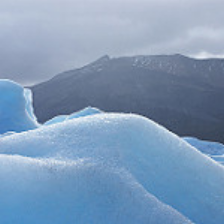

In [0]:
img = open_image(path/'train'/(str(result_index[0])+'.jpg'))
img.resize(224)

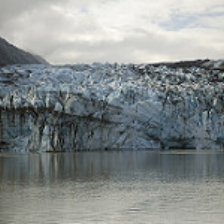

In [0]:
img = open_image(path/'train'/(str(result_index[1])+'.jpg'))
img.resize(224)

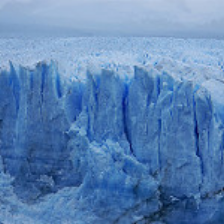

In [0]:
img = open_image(path/'train'/(str(result_index[2])+'.jpg'))
img.resize(224)

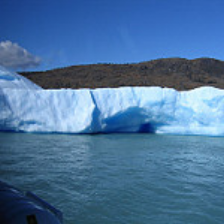

In [0]:
img = open_image(path/'train'/(str(result_index[3])+'.jpg'))
img.resize(224)

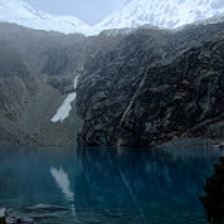

In [0]:
img = open_image(path/'train'/(str(result_index[4])+'.jpg'))
img.resize(224)

###K = 5

In [0]:
k = 5

In [0]:
top_k = list()
top_k_weigths = list()

In [0]:
for row in actual_test_df.iterrows():
  result_index = a_index.get_nns_by_vector(row[1]['embeddings'], k, include_distances=True)
  top_k.append(result_index[0])
  top_k_weigths.append(result_index[1])

In [0]:
actual_test_df[f'top_{k}'] = top_k

In [0]:
actual_test_df[f'top_{k}_weigths'] = top_k_weigths

In [0]:
actual_train_label=dict()

In [0]:
train_csv = pd.read_csv(path/'train.csv')

In [0]:
train_csv['image_name'] = train_csv.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_label = train_csv.set_index('image_name').to_dict()['label']

In [0]:
train_labels = list()
for row in top_k:
  img_labels = list()
  for img in row:
    img_labels.append(actual_train_label[img])
  train_labels.append(img_labels)

In [0]:
actual_test_df[f'train_labels_{k}'] = train_labels

In [0]:
top_k_voting_df = pd.DataFrame()
top_k_voting_df['image_name'] = actual_test_df['image_name']

In [0]:
label_list = list()
for label in train_labels:
  value = max(label,key=label.count)
  label_list.append(value)

In [0]:
top_k_voting_df['label'] = label_list

In [0]:
top_k_voting_df.head(10)

,image_name,label
4,22981.jpg,2
10,10017.jpg,2
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3
24,5961.jpg,5
32,8851.jpg,2
37,21039.jpg,0
39,7988.jpg,1
42,3642.jpg,1


In [0]:
top_k_voting_df.to_csv(f'top_{k}_voting_tta.csv', index=False)

Test Accuracy => 0.917351598173516

In [0]:
final_scores = list()

In [0]:
for index, labels in enumerate(train_labels):
  weigths_dict = dict()
  values = np.array(labels)
  weights = np.array(top_k_weigths[index])
  for label_id in range(6):
    ii = np.where(values == label_id)[0][:5]
    weigths_dict[np.sum(weights[ii])/min(ii.shape[0], 5)] =  label_id
  final_scores.append(weigths_dict)
      


In [0]:
actual_test_df[f"final_scores_{k}"] = final_scores

In [0]:
top_k_weighted_df = pd.DataFrame()

In [0]:
top_k_weighted_df['image_name'] = actual_test_df['image_name']

In [0]:
label_values = list()
for final_dict in final_scores:
  key = np.nanmin(list(final_dict.keys()))
#   print(k)
  label_values.append(final_dict[key])

In [0]:
top_k_weighted_df['label'] = label_values

In [0]:
top_k_weighted_df.head()

,image_name,label
4,22981.jpg,2
10,10017.jpg,3
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3


In [0]:
top_k_weighted_df.to_csv(f'top_{k}_weighted_tta.csv', index=False)

Test Accuracy => 0.875799086757991

###K = 10

In [0]:
k = 10

In [0]:
top_k = list()
top_k_weigths = list()

In [0]:
for row in actual_test_df.iterrows():
  result_index = a_index.get_nns_by_vector(row[1]['embeddings'], k, include_distances=True)
  top_k.append(result_index[0])
  top_k_weigths.append(result_index[1])

In [0]:
actual_test_df[f'top_{k}'] = top_k

In [0]:
actual_test_df[f'top_{k}_weigths'] = top_k_weigths

In [0]:
actual_train_label=dict()

In [0]:
train_csv = pd.read_csv(path/'train.csv')

In [0]:
train_csv['image_name'] = train_csv.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_label = train_csv.set_index('image_name').to_dict()['label']

In [0]:
train_labels = list()
for row in top_k:
  img_labels = list()
  for img in row:
    img_labels.append(actual_train_label[img])
  train_labels.append(img_labels)

In [0]:
actual_test_df[f'train_labels_{k}'] = train_labels

In [0]:
top_k_voting_df = pd.DataFrame()
top_k_voting_df['image_name'] = actual_test_df['image_name']

In [0]:
label_list = list()
for label in train_labels:
  value = max(label,key=label.count)
  label_list.append(value)

In [0]:
top_k_voting_df['label'] = label_list

In [0]:
top_k_voting_df.head(10)

,image_name,label
4,22981.jpg,2
10,10017.jpg,3
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3
24,5961.jpg,5
32,8851.jpg,2
37,21039.jpg,0
39,7988.jpg,1
42,3642.jpg,1


In [0]:
top_k_voting_df.to_csv(f'top_{k}_voting_tta.csv', index=False)

Test Accuracy => 0.921461187214612

In [0]:
final_scores = list()

In [0]:
for index, labels in enumerate(train_labels):
  weigths_dict = dict()
  values = np.array(labels)
  weights = np.array(top_k_weigths[index])
  for label_id in range(6):
    ii = np.where(values == label_id)[0][:5]
    weigths_dict[np.sum(weights[ii])/min(ii.shape[0], 5)] =  label_id
  final_scores.append(weigths_dict)
      


In [0]:
actual_test_df[f"final_scores_{k}"] = final_scores

In [0]:
top_k_weighted_df = pd.DataFrame()

In [0]:
top_k_weighted_df['image_name'] = actual_test_df['image_name']

In [0]:
label_values = list()
for final_dict in final_scores:
  key = np.nanmin(list(final_dict.keys()))
#   print(k)
  label_values.append(final_dict[key])

In [0]:
top_k_weighted_df['label'] = label_values

In [0]:
top_k_weighted_df.head()

,image_name,label
4,22981.jpg,2
10,10017.jpg,3
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3


In [0]:
top_k_weighted_df.to_csv(f'top_{k}_weighted_tta.csv', index=False)

Test Accuracy => 0.872146118721461

###K = 100

In [0]:
k = 100

In [0]:
top_k = list()
top_k_weigths = list()

In [0]:
for row in actual_test_df.iterrows():
  result_index = a_index.get_nns_by_vector(row[1]['embeddings'], k, include_distances=True)
  top_k.append(result_index[0])
  top_k_weigths.append(result_index[1])

In [0]:
actual_test_df[f'top_{k}'] = top_k

In [0]:
actual_test_df[f'top_{k}_weigths'] = top_k_weigths

In [0]:
actual_train_label=dict()

In [0]:
train_csv = pd.read_csv(path/'train.csv')

In [0]:
train_csv['image_name'] = train_csv.image_name.str.split('.').str.slice(0,1).str.join('').astype(int)

In [0]:
actual_train_label = train_csv.set_index('image_name').to_dict()['label']

In [0]:
train_labels = list()
for row in top_k:
  img_labels = list()
  for img in row:
    img_labels.append(actual_train_label[img])
  train_labels.append(img_labels)

In [0]:
actual_test_df[f'train_labels_{k}'] = train_labels

In [0]:
top_k_voting_df = pd.DataFrame()
top_k_voting_df['image_name'] = actual_test_df['image_name']

In [0]:
label_list = list()
for label in train_labels:
  value = max(label,key=label.count)
  label_list.append(value)

In [0]:
top_k_voting_df['label'] = label_list

In [0]:
top_k_voting_df.head(10)

,image_name,label
4,22981.jpg,2
10,10017.jpg,2
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3
24,5961.jpg,5
32,8851.jpg,2
37,21039.jpg,0
39,7988.jpg,1
42,3642.jpg,1


In [0]:
top_k_voting_df.to_csv(f'top_{k}_voting_tta.csv', index=False)

Test Accuracy => 0.929223744292237

In [0]:
final_scores = list()

In [0]:
for index, labels in enumerate(train_labels):
  weigths_dict = dict()
  values = np.array(labels)
  weights = np.array(top_k_weigths[index])
  for label_id in range(6):
    ii = np.where(values == label_id)[0][:5]
    weigths_dict[np.sum(weights[ii])/min(ii.shape[0], 5)] =  label_id
  final_scores.append(weigths_dict)
      


In [0]:
actual_test_df[f"final_scores_{k}"] = final_scores

In [0]:
top_k_weighted_df = pd.DataFrame()

In [0]:
top_k_weighted_df['image_name'] = actual_test_df['image_name']

In [0]:
label_values = list()
for final_dict in final_scores:
  key = np.nanmin(list(final_dict.keys()))
#   print(k)
  label_values.append(final_dict[key])

In [0]:
top_k_weighted_df['label'] = label_values

In [0]:
top_k_weighted_df.head()

,image_name,label
4,22981.jpg,2
10,10017.jpg,3
15,20923.jpg,1
21,7133.jpg,4
22,12854.jpg,3


In [0]:
top_k_weighted_df.to_csv(f'top_{k}_weighted_tta.csv', index=False)

Test Accuracy => 0.901826484018265